In [1]:
import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_ = plt.get_cmap('Set2')(np.linspace(0, 1, 8))
colors_year = plt.get_cmap('magma')(np.linspace(0.5, 1, 5)[::-1][1:])

from IPython.core.pylabtools import figsize
from IPython.display import display
figsize(8, 5)

from plot import annotate

%load_ext watermark
%load_ext autoreload
%autoreload 2
%matplotlib inline

%watermark -d -t -u -v -g -r -b -iv -a "Hongsup Shin" 

Author: Hongsup Shin

Last updated: 2021-01-23 23:02:47

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Git hash: 7e011f383cbb32927b6c80787dc775f230502ce7

Git repo: https://github.com/texas-justice-initiative/officer_involved_shooting_report_2020.git

Git branch: data-qa

pandas    : 1.2.0
numpy     : 1.19.5
seaborn   : 0.11.1
matplotlib: 3.3.3



# Assess the data quality of multi-individual incidents

## 1. Motivation 

There are **multiple columns** that show the information about **the number of the involved party** in both civilian and officer datasets. We need to know

1. **which columns provide more reliable information than others**
2. **whether there exist discrepancies between these columns**

## 2. Columns that show the number of the involved party

### 2.1. Civilian data (the involved party = officers)

1. `multiple_officers_involved` (Boolean): `True` if yes, `False` otherwise.
2. `num_officers_recorded` (integer): the number of officers
3. Demographic information
    - `officer_race_*` (string)
    - `officer_age_*` (integer)
    - `officer_gender_*` (string)

- **Assumption 1. We assume that these demographic columns with different suffixes (e.g., `officer_race_1`, `officer_race_2`, etc.) represent different individuals.** This means given a report (a single row), we can count the number of the race columns that are populated, which will be the number of officers involved.
- **Warning. Granularity of demographic information might be inconsistent.** For instance, a report might have information about an officer's gender but not age, or their race but not gender, and so on. To check the consistency between `num_officers_recorded` and the demographic columns, we will have to do *union* (i.e., one of the demographic columns (age, race, or gender) is not null, we count it).

### 2.2 Officer data (the involved party = civilians)
1. `num_civilians_recorded` (integer): the number of civilians
2. Demographic information
    - `civilian_race_*`
    - `civilian_age_*`
    - `civilian_gender_*`
    - **`civilian_name_first_*`**
    - **`civilian_name_last_*`**
- The above-mentioned assumption and warning are applied to the officer data too.

## 3. Officers in the civilian data 

In [2]:
df_cd = pd.read_pickle('../Data/Preprocessed/civilian_shooting_preprocessed.pkl'); print(df_cd.shape)

(697, 154)


### 3.1 Size of the involved party (`num_officers_recorded` vs. officer demographic data)

Method

1. Starting from the first individual (suffix `1`), check all three demographic columns (race, age, gender) for each individual
2. If at least one of the three columns have some information (union), we count this as one of the officers.

|officer_race_1|officer_age_1|officer_gender|**<font color='red'>Count this as an officer?</font>**|
|--------------|-------------|--------------|-----------------------------|
|White|26|Male|Yes|
|Black|||**Yes**|

In [3]:
dem_keys = ['race', 'age', 'gender']
n_officers_max = 11

# checking
officer_inds = np.arange(1, n_officers_max + 1)
inferred_officer_existence = {}
for ind in officer_inds:
    
    # select all three demographic columns for each individual
    cols = ['officer_{}_{}'.format(dem_key, ind) for dem_key in dem_keys]
    
    # if at least one of the three dem_keys are not na then count
    inferred_officer_existence[ind] = df_cd[cols].notna().sum(axis=1) > 0    
df_inferred_officer_existence = pd.DataFrame(inferred_officer_existence)
inferred_num_officers_recorded = df_inferred_officer_existence.sum(axis=1)

In [4]:
df_compared_officers = pd.concat([df_cd['num_officers_recorded'].value_counts().sort_index(),
                                  inferred_num_officers_recorded.value_counts().sort_index()], axis=1)
df_compared_officers.columns = ['num_officers_recorded', 'INFERRED_num_officers_recorded']
df_compared_officers['diff'] = df_compared_officers['INFERRED_num_officers_recorded'] - df_compared_officers['num_officers_recorded']

In [5]:
df_compared_officers

,num_officers_recorded,INFERRED_num_officers_recorded,diff
1,447.0,447,0.0
2,126.0,126,0.0
3,48.0,48,0.0
4,35.0,35,0.0
5,20.0,20,0.0
6,7.0,7,0.0
7,7.0,7,0.0
8,2.0,2,0.0
9,2.0,2,0.0
10,3.0,2,-1.0


**There is only one mismatch.**

In [6]:
df_cd.loc[df_cd['num_officers_recorded'] != inferred_num_officers_recorded]

,date_ag_received,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,...,month,died,Traffic Stop,Emergency/Request for Assistance,Execution of a Warrant,Hostage/Barricade/Other Emergency,Other,civilian_age_binned,delay_days,delay_bin_label
462,2018-05-23,2018-04-23,1000 IKEA WAY,GRAND PRAIRIE,DALLAS,75052.0,OTHER - SPECIFY TYPE OF CALL,WELFARE CHECK,CARLOS DEONE,HIGH,...,4,True,0,0,0,0,1,4,30.0,3


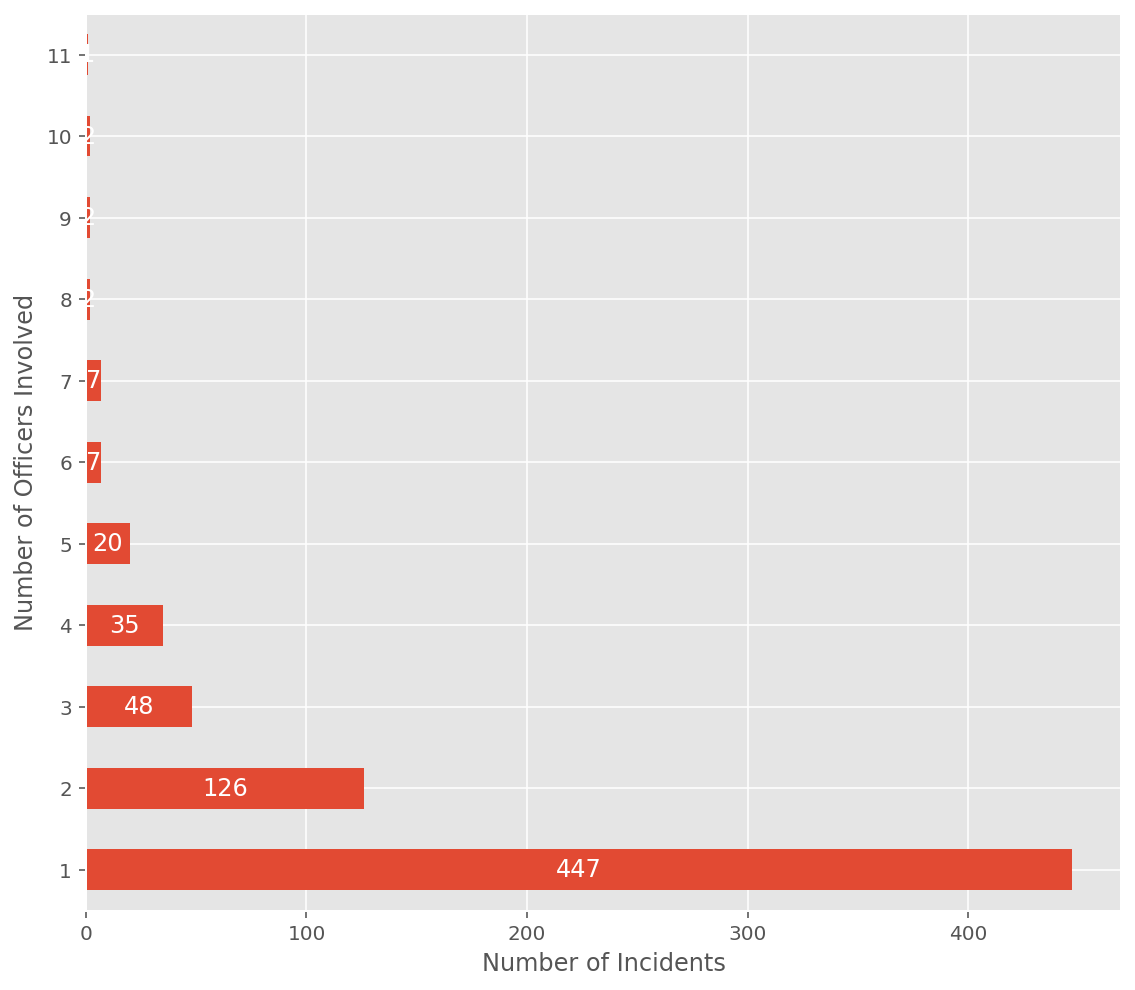

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
df_compared_officers['INFERRED_num_officers_recorded'].plot(kind='barh', rot=0, ax=ax)
ax.set(ylabel='Number of Officers Involved', xlabel='Number of Incidents')
annotate(ax, 'h', fontsize=12)
fig.tight_layout()

### 3.1 Quality of each demographic data
We will want to use the demographic inforation separately for futher analyses. Thus, we need to assess the quality of each demographic data separatey.

In [8]:
dem_keys = ['race', 'age', 'gender']
inferred_officer_existence_by_dem_keys = {}
df_compared_officers_by_dem_keys = {}
for dem_key in dem_keys:
    
    cols = df_cd.columns[df_cd.columns.str.contains('officer_{}'.format(dem_key))]
    inferred_officer_existence_by_dem_keys[dem_key] = df_cd[cols].notna().sum(axis=1)
    df_compared_officers_by_dem_keys[dem_key] = df_cd[cols].notna().sum(axis=1).value_counts().sort_index()
df_inferred_officer_existence_by_dem_keys = pd.DataFrame(inferred_officer_existence_by_dem_keys)
df_compared_officers_by_dem_keys = pd.DataFrame(df_compared_officers_by_dem_keys)

In [9]:
df_compared_officers_by_dem_keys

,race,age,gender
1,447,447,447
2,127,127,126
3,47,47,48
4,35,35,35
5,20,20,20
6,7,7,7
7,7,7,7
8,2,2,2
9,2,2,2
10,2,2,2


There are only a couple of mismatched cases. 

Note: the index above means the number of missing data (not the number of officers involved).

## 4. Civilians in the officer data
Applying the same approach as the above

In [10]:
df_os = pd.read_pickle('../Data/Preprocessed/officer_shooting_preprocessed.pkl'); print(df_os.shape)

(130, 50)


### 4.1 Size of the involved party (`num_civilians_recorded` vs. civilian demographic data)
Compared to the officer's, civilian demographic data also has first and last names.

In [11]:
dem_keys = ['race', 'age', 'gender', 'name_first', 'name_last']
n_civilians_max = 3

# checking
civilian_inds = np.arange(1, n_civilians_max + 1)
inferred_civilian_existence = {}
for ind in civilian_inds:
    
    # select all three demographic columns for each individual
    cols = ['civilian_{}_{}'.format(dem_key, ind) for dem_key in dem_keys]
    
    # if at least one of the three dem_keys are not na then count
    inferred_civilian_existence[ind] = df_os[cols].notna().sum(axis=1) > 0  
    
df_inferred_civilian_existence = pd.DataFrame(inferred_civilian_existence)
inferred_num_civilians_recorded = df_inferred_civilian_existence.sum(axis=1)

In [12]:
df_compared_civilians = pd.concat([df_os['num_civilians_recorded'].value_counts().sort_index(),
                                  inferred_num_civilians_recorded.value_counts().sort_index()], axis=1)
df_compared_civilians.columns = ['num_civilians_recorded', 'INFERRED_num_civilians_recorded']
df_compared_civilians['diff'] = df_compared_civilians['INFERRED_num_civilians_recorded'] - df_compared_civilians['num_civilians_recorded']

In [13]:
df_compared_civilians

,num_civilians_recorded,INFERRED_num_civilians_recorded,diff
0,1,1,0
1,120,120,0
2,8,8,0
3,1,1,0


**There is no mismatch.**

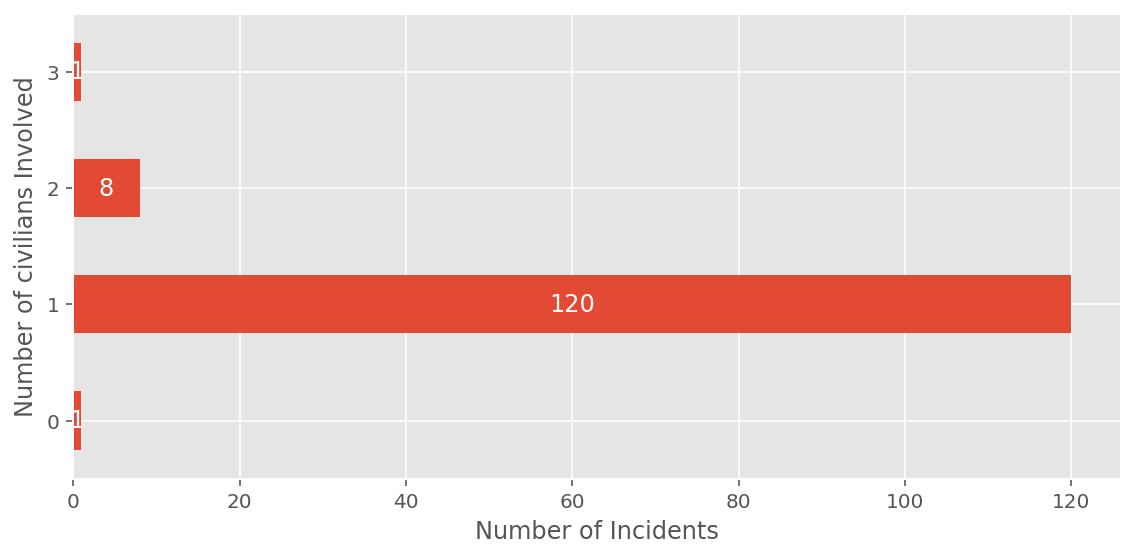

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df_compared_civilians['INFERRED_num_civilians_recorded'].plot(kind='barh', rot=0, ax=ax)
ax.set(ylabel='Number of civilians Involved', xlabel='Number of Incidents')
annotate(ax, 'h', fontsize=12)
fig.tight_layout()

### Odd case: `num_civilians_recorded` = 0
https://www.click2houston.com/news/2016/01/14/officer-released-from-hospital-after-shot-in-the-leg-in-third-ward/
>"HPD is currently looking for the shooter."

In [15]:
df_os[df_os['num_civilians_recorded']==0]

,date_ag_received,date_incident,incident_address,incident_city,incident_county,incident_zip,officer_harm,officer_name_first,officer_name_last,officer_age,...,civilian_name_last_3,civilian_age_3,civilian_race_3,civilian_gender_3,media_link_1,media_link_2,media_link_3,year,month,delay_days
5,NaT,2016-01-13,3100 ANITA,HOUSTON,HARRIS,77004,INJURY,KENNETH,FREGIA,46.0,...,NaN,NaN,NaN,NaN,CHRONICLE,ABC 13,NaN,2016,1,NaN


### 4.1 Quality of each demographic data

In [16]:
dem_keys = ['race', 'age', 'gender', 'name_first', 'name_last']
inferred_civilian_existence_by_dem_keys = {}
df_compared_civilians_by_dem_keys = {}
for dem_key in dem_keys:
    
    cols = df_os.columns[df_os.columns.str.contains('civilian_{}'.format(dem_key))]
    inferred_civilian_existence_by_dem_keys[dem_key] = df_os[cols].notna().sum(axis=1)
    df_compared_civilians_by_dem_keys[dem_key] = df_os[cols].notna().sum(axis=1).value_counts().sort_index()
df_inferred_civilian_existence_by_dem_keys = pd.DataFrame(inferred_civilian_existence_by_dem_keys)
df_compared_civilians_by_dem_keys = pd.DataFrame(df_compared_civilians_by_dem_keys)

In [17]:
df_compared_civilians_by_dem_keys

,race,age,gender,name_first,name_last
0,5,9,3,25.0,24.0
1,116,113,118,99.0,100.0
2,8,7,8,6.0,6.0
3,1,1,1,NaN,NaN


**Compared to officer data, the civiliand data is less well-populated; more missing data exist (first row of index 0).**

Note: the index above means the number of missing data (not the number of civilians involved).

## To do
- Check `officer_caused_injury_*` columns. Strangely, the suffix (`*`) starts with 2 not 1. In other words, where's `officer_caused_injury_1`? (It doesn't exist in the raw data either.)
- Brainstorm as a group to think about potential factors that can affect police shooting
- Check the quality of identification of demographic data of **civilians**

## !!!Questions!!!

1. Is the number of the individials in the involved party identical to the number of shooters?
2. If not, how do we identify who among the involved party are the shooters?
3. If the victim died during the incident, does it matter to identify who made the fatal shot?